In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import numpy as np
from os import listdir
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf
import math
import sklearn.model_selection as sk

In [5]:
!ls "drive/Colab Notebooks"

checkpoint			       model22	    Seq2Seq.ipynb
circles				       model23	    test_images.npy
Copy of 5steps_object_detection.ipynb  model_norm3  test_labels.npy
files.json			       model_norm4  train_images.npy
iseq.npy			       model_norm5  train_labels.npy
latex				       Nash.ipynb   Untitled0.ipynb
latex.ipynb			       oseq.npy
latex_or.ipynb			       Seq


In [0]:
label_names = ['Delta', '{', 'gt', '4', 'G', 'theta', 'R', 'k', 'i', 'lim', '(', 'b', 'sum', 'u', 'leq', 'o', 'ascii_124', ',', '0', 'ldots', 'forward_slash', '}', 'beta', 'lambda', 'pm', 'pi', 'neq', 'phi', 'p', 'geq', 'j', 'v', '2', 'S', 'd', 'sigma', 'log', 'C', 'sin', '3', 'y', 'sqrt', 'forall', 'M', 'T', 'times', 'mu', 'X', 'rightarrow', '=', ']', 'in', '-', 'None', 'z', 'div', 'w', '+', '!', 'f', '8', '6', '5', 'int', 'H', 'A', 'cos', 'N', 'tan', '1', '7', 'prime', 'infty', 'alpha', 'e', '9', 'lt', '[', 'exists', ')', 'q', 'gamma', 'l']
label_names = ['0','1','2','3','4','5','6','7','8','9','-','+','=','leq','geq','neq']
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-', '+', '=', 'leq', 'neq', 'geq', 'alpha',
               'beta', 'lambda', 'x', 'y']
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-', '+', '=', 'leq', 'neq', 'geq', 'alpha',
               'beta', 'lambda', 'lt', 'gt', 'x', 'y']

In [0]:
nof_labels = len(label_names)

In [0]:
train_images = np.load("drive/Colab Notebooks/train_images.npy")
train_labels = np.load("drive/Colab Notebooks/train_labels.npy")

In [0]:
test_images = np.load("drive/Colab Notebooks/test_images.npy")
test_labels = np.load("drive/Colab Notebooks/test_labels.npy")

In [17]:
print("Range in train: ", np.min(train_images), np.max(train_images))

Range in train:  0.0 1.0


In [0]:
mean_tr = np.mean(train_images, axis=0)
std_tr = np.std(train_images, axis=0)
train_images -= mean_tr
train_images /= std_tr
test_images -= mean_tr
test_images /= std_tr

In [19]:
print("Range in train: ", np.min(train_images), np.max(train_images))

Range in train:  -237.77185 0.62998265


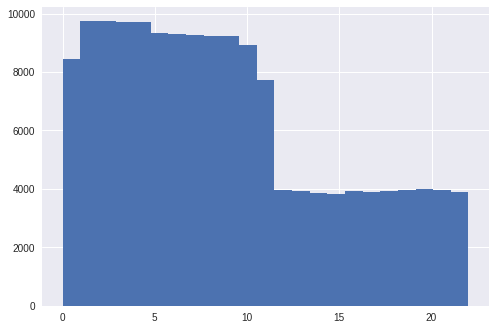

In [10]:
plt.hist(train_labels, nof_labels)
plt.show()

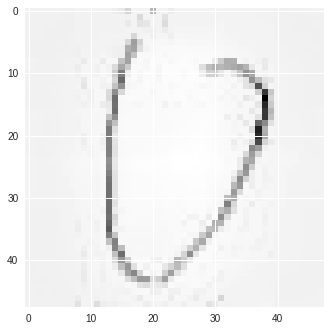

0


In [12]:
no = 1824
plt.imshow(train_images[no], cmap='gray')
plt.show()
print(label_names[train_labels[no]])

In [0]:
nof_train_images = train_images.shape[0]

In [0]:
def cnn_model_fn(features, labels, mode):
    input_layer = tf.reshape(features["x"], [-1,48,48,1])
       
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 32,
        kernel_size = [7,7],
        padding="same",
        activation=tf.nn.relu
    )
    
    pool1 = tf.layers.max_pooling2d(
        inputs = conv1,
        pool_size=[2,2],
        strides=2
    )
    
    conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 64,
        kernel_size = [7,7],
        padding="same",
        activation=tf.nn.relu
    )
    
    pool2 = tf.layers.max_pooling2d(
        inputs = conv2,
        pool_size=[2,2],
        strides=2
    )
    
    conv3 = tf.layers.conv2d(
        inputs = pool2,
        filters = 128,
        kernel_size = [7,7],
        padding="same",
        activation=tf.nn.relu
    )
    
    pool3 = tf.layers.max_pooling2d(
        inputs = conv3,
        pool_size=[2,2],
        strides=2
    )
    
    pool3_flat = tf.reshape(pool3, [-1, 6*6*128])
    dense = tf.layers.dense(inputs=pool3_flat, units=2048, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense,
        rate=0.4,
        training=mode == tf.estimator.ModeKeys.TRAIN
    )
    
    # units = number of symbols
    logits = tf.layers.dense(inputs=dropout, units=nof_labels)
    
    predictions = {
        # generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,predictions=predictions)
    
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=nof_labels)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits
    )
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss = loss,
            global_step=tf.train.get_global_step()
        )
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels,
            predictions=predictions["classes"]
        )
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [22]:
classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="drive/Colab Notebooks/model_norm5"
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'drive/Colab Notebooks/model_norm5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcab01dc6a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
tensors_to_log = {} #"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50
)

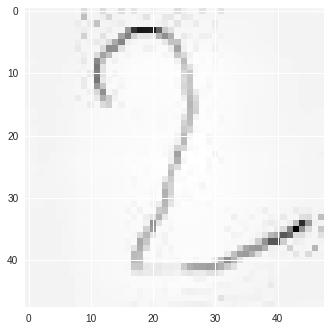

2


In [17]:
no = 9000
plt.imshow(test_images[no], cmap='gray')
plt.show()
print(label_names[test_labels[no]])

In [18]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": train_images},
    y = train_labels,
    batch_size = 500,
    num_epochs = None,
    shuffle = True
)
classifier.train(
    input_fn = train_input_fn,
    steps = 40000,
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into drive/Colab Notebooks/model_norm5/model.ckpt.
INFO:tensorflow:loss = 3.1921902, step = 0
INFO:tensorflow:global_step/sec: 7.44666
INFO:tensorflow:loss = 2.5700855, step = 100 (13.448 sec)
INFO:tensorflow:global_step/sec: 7.46301
INFO:tensorflow:loss = 0.17618029, step = 200 (13.382 sec)
INFO:tensorflow:global_step/sec: 7.49995
INFO:tensorflow:loss = 0.030094625, step = 300 (13.341 sec)
INFO:tensorflow:global_step/sec: 7.11395
INFO:tensorflow:loss = 0.010921536, step = 400 (14.055 sec)
INFO:tensorflow:global_step/sec: 7.56374
INFO:tensorflow:loss = 0.051369324, step = 500 (13.221 sec)
INFO:tensorflow:global_step/sec: 7.55017
INFO:tensorflow:loss = 0.21938954, step = 600 (13.241 sec)
INFO:tensorflow:global_ste


INFO:tensorflow:global_step/sec: 7.18139
INFO:tensorflow:loss = 0.0040667863, step = 2800 (13.925 sec)
INFO:tensorflow:global_step/sec: 7.58352
INFO:tensorflow:loss = 0.042949297, step = 2900 (13.191 sec)
INFO:tensorflow:global_step/sec: 7.58664
INFO:tensorflow:loss = 0.008204527, step = 3000 (13.179 sec)
INFO:tensorflow:global_step/sec: 7.52563
INFO:tensorflow:loss = 0.013501282, step = 3100 (13.288 sec)
INFO:tensorflow:global_step/sec: 7.50967
INFO:tensorflow:loss = 0.0035813951, step = 3200 (13.316 sec)
INFO:tensorflow:global_step/sec: 7.51423
INFO:tensorflow:loss = 0.0082261795, step = 3300 (13.307 sec)
INFO:tensorflow:global_step/sec: 7.08083
INFO:tensorflow:loss = 0.56192, step = 3400 (14.140 sec)
INFO:tensorflow:global_step/sec: 7.51105
INFO:tensorflow:loss = 0.009589799, step = 3500 (13.299 sec)
INFO:tensorflow:global_step/sec: 7.52261
INFO:tensorflow:loss = 0.014196307, step = 3600 (13.291 sec)
INFO:tensorflow:global_step/sec: 7.50373
INFO:tensorflow:loss = 0.0024141495, step

INFO:tensorflow:loss = 0.043244842, step = 5700 (13.287 sec)
INFO:tensorflow:global_step/sec: 7.52678
INFO:tensorflow:loss = 0.059388462, step = 5800 (13.285 sec)
INFO:tensorflow:global_step/sec: 7.51933
INFO:tensorflow:loss = 0.0079055205, step = 5900 (13.324 sec)
INFO:tensorflow:global_step/sec: 7.5055
INFO:tensorflow:loss = 0.0013398806, step = 6000 (13.303 sec)
INFO:tensorflow:global_step/sec: 7.53728
INFO:tensorflow:loss = 0.12014458, step = 6100 (13.263 sec)
INFO:tensorflow:global_step/sec: 7.068
INFO:tensorflow:loss = 0.00091120903, step = 6200 (14.153 sec)
INFO:tensorflow:global_step/sec: 7.50164
INFO:tensorflow:loss = 0.0048737526, step = 6300 (13.329 sec)
INFO:tensorflow:global_step/sec: 7.52692
INFO:tensorflow:loss = 0.07204175, step = 6400 (13.287 sec)
INFO:tensorflow:global_step/sec: 7.49742
INFO:tensorflow:loss = 0.0078036697, step = 6500 (13.333 sec)
INFO:tensorflow:global_step/sec: 7.50633
INFO:tensorflow:loss = 0.0011348316, step = 6600 (13.324 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 0.0042225416, step = 8700 (13.330 sec)
INFO:tensorflow:Saving checkpoints for 8717 into drive/Colab Notebooks/model_norm5/model.ckpt.
INFO:tensorflow:global_step/sec: 2.26872
INFO:tensorflow:loss = 0.029554537, step = 8800 (44.078 sec)
INFO:tensorflow:global_step/sec: 7.06634
INFO:tensorflow:loss = 0.00294916, step = 8900 (14.147 sec)
INFO:tensorflow:global_step/sec: 7.50572
INFO:tensorflow:loss = 0.002520251, step = 9000 (13.323 sec)
INFO:tensorflow:global_step/sec: 7.5182
INFO:tensorflow:loss = 0.028103694, step = 9100 (13.301 sec)
INFO:tensorflow:global_step/sec: 7.50474
INFO:tensorflow:loss = 0.019718578, step = 9200 (13.326 sec)
INFO:tensorflow:global_step/sec: 7.51338
INFO:tensorflow:loss = 0.0009064396, step = 9300 (14.095 sec)
INFO:tensorflow:global_step/sec: 7.10785
INFO:tensorflow:loss = 0.03517662, step = 9400 (13.285 sec)
INFO:tensorflow:global_step/sec: 7.51603
INFO:tensorflow:loss = 0.014211279, step = 9500 (13.308 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 7.1145
INFO:tensorflow:loss = 0.005364403, step = 11700 (14.056 sec)
INFO:tensorflow:global_step/sec: 7.53295
INFO:tensorflow:loss = 0.0003736426, step = 11800 (13.278 sec)
INFO:tensorflow:global_step/sec: 7.51567
INFO:tensorflow:loss = 0.0050428463, step = 11900 (13.310 sec)
INFO:tensorflow:global_step/sec: 7.50558
INFO:tensorflow:loss = 0.026928056, step = 12000 (13.339 sec)
INFO:tensorflow:global_step/sec: 7.52308
INFO:tensorflow:loss = 0.0054498543, step = 12100 (13.274 sec)
INFO:tensorflow:global_step/sec: 7.57565
INFO:tensorflow:loss = 0.06847892, step = 12200 (13.196 sec)
INFO:tensorflow:global_step/sec: 7.17202
INFO:tensorflow:loss = 0.0010364426, step = 12300 (13.949 sec)
INFO:tensorflow:global_step/sec: 7.54671
INFO:tensorflow:loss = 0.015850611, step = 12400 (13.250 sec)
INFO:tensorflow:global_step/sec: 7.51637
INFO:tensorflow:loss = 0.020353893, step = 12500 (13.302 sec)
INFO:tensorflow:global_step/sec: 7.50972
INFO:tensorflow:loss = 0.01699

INFO:tensorflow:global_step/sec: 7.57717
INFO:tensorflow:loss = 0.0011252306, step = 14600 (13.177 sec)
INFO:tensorflow:global_step/sec: 7.53164
INFO:tensorflow:loss = 0.029546224, step = 14700 (13.275 sec)
INFO:tensorflow:global_step/sec: 7.14959
INFO:tensorflow:loss = 0.031511247, step = 14800 (13.987 sec)
INFO:tensorflow:global_step/sec: 7.51501
INFO:tensorflow:loss = 0.00020661062, step = 14900 (13.307 sec)
INFO:tensorflow:global_step/sec: 7.51782
INFO:tensorflow:loss = 0.028700126, step = 15000 (13.308 sec)
INFO:tensorflow:global_step/sec: 7.49519
INFO:tensorflow:loss = 0.0007779033, step = 15100 (13.335 sec)
INFO:tensorflow:global_step/sec: 7.50696
INFO:tensorflow:loss = 0.00043352233, step = 15200 (13.327 sec)
INFO:tensorflow:global_step/sec: 7.51845
INFO:tensorflow:loss = 0.0018465323, step = 15300 (13.295 sec)
INFO:tensorflow:global_step/sec: 7.12004
INFO:tensorflow:loss = 0.014452972, step = 15400 (14.067 sec)
INFO:tensorflow:global_step/sec: 7.5002
INFO:tensorflow:loss = 0.0

INFO:tensorflow:loss = 0.007655752, step = 17500 (14.000 sec)
INFO:tensorflow:global_step/sec: 7.50318
INFO:tensorflow:loss = 0.014446234, step = 17600 (13.331 sec)
INFO:tensorflow:global_step/sec: 7.49752
INFO:tensorflow:loss = 0.017770955, step = 17700 (13.340 sec)
INFO:tensorflow:global_step/sec: 7.49532
INFO:tensorflow:loss = 0.0056367815, step = 17800 (13.340 sec)
INFO:tensorflow:global_step/sec: 7.49777
INFO:tensorflow:loss = 0.0042431303, step = 17900 (13.337 sec)
INFO:tensorflow:global_step/sec: 7.51034
INFO:tensorflow:loss = 0.0039182883, step = 18000 (14.049 sec)
INFO:tensorflow:global_step/sec: 7.12928
INFO:tensorflow:loss = 0.011039759, step = 18100 (13.312 sec)
INFO:tensorflow:global_step/sec: 7.49821
INFO:tensorflow:loss = 0.0012895968, step = 18200 (13.317 sec)
INFO:tensorflow:global_step/sec: 7.50861
INFO:tensorflow:loss = 0.08537421, step = 18300 (13.325 sec)
INFO:tensorflow:global_step/sec: 7.51014
INFO:tensorflow:loss = 0.0014934168, step = 18400 (13.314 sec)
INFO:te

INFO:tensorflow:global_step/sec: 7.07074
INFO:tensorflow:loss = 0.0009911334, step = 20500 (14.141 sec)
INFO:tensorflow:global_step/sec: 7.49975
INFO:tensorflow:loss = 0.011151919, step = 20600 (13.331 sec)
INFO:tensorflow:global_step/sec: 7.52243
INFO:tensorflow:loss = 0.0024750647, step = 20700 (13.298 sec)
INFO:tensorflow:global_step/sec: 7.49552
INFO:tensorflow:loss = 0.0026222824, step = 20800 (13.357 sec)
INFO:tensorflow:global_step/sec: 7.50588
INFO:tensorflow:loss = 0.04515141, step = 20900 (13.308 sec)
INFO:tensorflow:global_step/sec: 7.50103
INFO:tensorflow:loss = 0.0060930233, step = 21000 (13.328 sec)
INFO:tensorflow:global_step/sec: 7.1386
INFO:tensorflow:loss = 0.002776287, step = 21100 (14.009 sec)
INFO:tensorflow:global_step/sec: 7.52146
INFO:tensorflow:loss = 0.003243833, step = 21200 (13.295 sec)
INFO:tensorflow:global_step/sec: 7.49929
INFO:tensorflow:loss = 0.06119452, step = 21300 (13.332 sec)
INFO:tensorflow:Saving checkpoints for 21400 into drive/Colab Notebooks/

INFO:tensorflow:global_step/sec: 7.51083
INFO:tensorflow:loss = 0.004078859, step = 23400 (13.294 sec)
INFO:tensorflow:global_step/sec: 7.52252
INFO:tensorflow:loss = 0.002838285, step = 23500 (13.296 sec)
INFO:tensorflow:global_step/sec: 7.15213
INFO:tensorflow:loss = 0.01559999, step = 23600 (13.987 sec)
INFO:tensorflow:global_step/sec: 7.50999
INFO:tensorflow:loss = 0.006665268, step = 23700 (13.311 sec)
INFO:tensorflow:global_step/sec: 7.51683
INFO:tensorflow:loss = 0.0019653956, step = 23800 (13.304 sec)
INFO:tensorflow:global_step/sec: 7.54958
INFO:tensorflow:loss = 0.010762052, step = 23900 (13.245 sec)
INFO:tensorflow:global_step/sec: 7.56447
INFO:tensorflow:loss = 0.0064443033, step = 24000 (13.222 sec)
INFO:tensorflow:global_step/sec: 7.5771
INFO:tensorflow:loss = 0.059327725, step = 24100 (13.199 sec)
INFO:tensorflow:global_step/sec: 7.09532
INFO:tensorflow:loss = 0.002061376, step = 24200 (14.108 sec)
INFO:tensorflow:global_step/sec: 7.51015
INFO:tensorflow:loss = 0.0078663

INFO:tensorflow:loss = 0.0071006864, step = 26300 (13.210 sec)
INFO:tensorflow:global_step/sec: 7.58188
INFO:tensorflow:loss = 0.0017579228, step = 26400 (13.187 sec)
INFO:tensorflow:global_step/sec: 7.5389
INFO:tensorflow:loss = 0.024729038, step = 26500 (13.266 sec)
INFO:tensorflow:global_step/sec: 7.55964
INFO:tensorflow:loss = 0.011010789, step = 26600 (13.232 sec)
INFO:tensorflow:global_step/sec: 7.12116
INFO:tensorflow:loss = 0.0026597353, step = 26700 (14.060 sec)
INFO:tensorflow:global_step/sec: 7.52965
INFO:tensorflow:loss = 0.0001930504, step = 26800 (13.259 sec)
INFO:tensorflow:global_step/sec: 7.55364
INFO:tensorflow:loss = 0.0083405385, step = 26900 (13.242 sec)
INFO:tensorflow:global_step/sec: 7.52685
INFO:tensorflow:loss = 0.016542846, step = 27000 (13.281 sec)
INFO:tensorflow:global_step/sec: 7.54577
INFO:tensorflow:loss = 0.0015785516, step = 27100 (13.255 sec)
INFO:tensorflow:global_step/sec: 7.54559
INFO:tensorflow:loss = 0.0024473544, step = 27200 (13.250 sec)
INFO:

INFO:tensorflow:global_step/sec: 7.52829
INFO:tensorflow:loss = 0.06084497, step = 29300 (13.283 sec)
INFO:tensorflow:global_step/sec: 7.5242
INFO:tensorflow:loss = 0.004197954, step = 29400 (13.306 sec)
INFO:tensorflow:global_step/sec: 7.49261
INFO:tensorflow:loss = 0.002605111, step = 29500 (13.328 sec)
INFO:tensorflow:global_step/sec: 7.49912
INFO:tensorflow:loss = 0.0018742833, step = 29600 (13.340 sec)
INFO:tensorflow:global_step/sec: 7.11495
INFO:tensorflow:loss = 0.001352128, step = 29700 (14.050 sec)
INFO:tensorflow:global_step/sec: 7.52582
INFO:tensorflow:loss = 0.00074737327, step = 29800 (13.295 sec)
INFO:tensorflow:Saving checkpoints for 29831 into drive/Colab Notebooks/model_norm5/model.ckpt.
INFO:tensorflow:global_step/sec: 2.10048
INFO:tensorflow:loss = 0.005013289, step = 29900 (47.623 sec)
INFO:tensorflow:global_step/sec: 7.50333
INFO:tensorflow:loss = 0.003927504, step = 30000 (13.312 sec)
INFO:tensorflow:global_step/sec: 7.48718
INFO:tensorflow:loss = 0.0014861207, s

INFO:tensorflow:global_step/sec: 7.5503
INFO:tensorflow:loss = 0.0040220474, step = 32200 (13.248 sec)
INFO:tensorflow:global_step/sec: 7.51939
INFO:tensorflow:loss = 0.0032906404, step = 32300 (13.300 sec)
INFO:tensorflow:global_step/sec: 7.536
INFO:tensorflow:loss = 0.00044186023, step = 32400 (13.272 sec)
INFO:tensorflow:global_step/sec: 7.55398
INFO:tensorflow:loss = 0.08087898, step = 32500 (13.233 sec)
INFO:tensorflow:global_step/sec: 7.12167
INFO:tensorflow:loss = 0.00026479003, step = 32600 (14.042 sec)
INFO:tensorflow:global_step/sec: 7.52706
INFO:tensorflow:loss = 0.0025651278, step = 32700 (13.285 sec)
INFO:tensorflow:global_step/sec: 7.50988
INFO:tensorflow:loss = 0.008491661, step = 32800 (13.319 sec)
INFO:tensorflow:global_step/sec: 7.52675
INFO:tensorflow:loss = 0.0006513353, step = 32900 (13.305 sec)
INFO:tensorflow:global_step/sec: 7.51118
INFO:tensorflow:loss = 0.0006263614, step = 33000 (13.290 sec)
INFO:tensorflow:global_step/sec: 7.54996
INFO:tensorflow:loss = 0.00

INFO:tensorflow:loss = 0.00291531, step = 35100 (14.158 sec)
INFO:tensorflow:global_step/sec: 7.51057
INFO:tensorflow:loss = 0.0014590411, step = 35200 (13.313 sec)
INFO:tensorflow:global_step/sec: 7.50116
INFO:tensorflow:loss = 0.003181201, step = 35300 (13.334 sec)
INFO:tensorflow:global_step/sec: 7.50413
INFO:tensorflow:loss = 0.0005131889, step = 35400 (13.345 sec)
INFO:tensorflow:global_step/sec: 7.50936
INFO:tensorflow:loss = 0.009451132, step = 35500 (13.296 sec)
INFO:tensorflow:global_step/sec: 7.51638
INFO:tensorflow:loss = 0.0022556568, step = 35600 (13.308 sec)
INFO:tensorflow:global_step/sec: 7.13768
INFO:tensorflow:loss = 0.00027730648, step = 35700 (14.007 sec)
INFO:tensorflow:global_step/sec: 7.52727
INFO:tensorflow:loss = 0.05118433, step = 35800 (13.290 sec)
INFO:tensorflow:global_step/sec: 7.52899
INFO:tensorflow:loss = 0.00015590638, step = 35900 (13.280 sec)
INFO:tensorflow:global_step/sec: 7.50836
INFO:tensorflow:loss = 0.00095044286, step = 36000 (13.318 sec)
INFO

INFO:tensorflow:loss = 0.00029370622, step = 38100 (14.239 sec)
INFO:tensorflow:global_step/sec: 7.4966
INFO:tensorflow:loss = 0.00091897516, step = 38200 (13.317 sec)
INFO:tensorflow:Saving checkpoints for 38290 into drive/Colab Notebooks/model_norm5/model.ckpt.
INFO:tensorflow:global_step/sec: 1.9932
INFO:tensorflow:loss = 0.00025610905, step = 38300 (50.173 sec)
INFO:tensorflow:global_step/sec: 7.4971
INFO:tensorflow:loss = 0.0009246566, step = 38400 (13.337 sec)
INFO:tensorflow:global_step/sec: 7.50156
INFO:tensorflow:loss = 0.00078030117, step = 38500 (13.330 sec)
INFO:tensorflow:global_step/sec: 7.50697
INFO:tensorflow:loss = 0.0005006572, step = 38600 (13.339 sec)
INFO:tensorflow:global_step/sec: 7.49528
INFO:tensorflow:loss = 0.004634005, step = 38700 (13.329 sec)
INFO:tensorflow:global_step/sec: 7.5173
INFO:tensorflow:loss = 0.001145882, step = 38800 (14.089 sec)
INFO:tensorflow:global_step/sec: 7.0918
INFO:tensorflow:loss = 0.0022955714, step = 38900 (13.313 sec)
INFO:tensorf

In [0]:
nof_test_images = test_images.shape[0]

Testing on #images:  5245


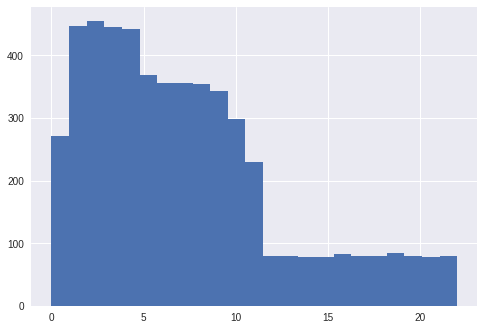

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-19-21:12:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from drive/Colab Notebooks/model_norm5/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-19-21:13:05
INFO:tensorflow:Saving dict for global step 40000: accuracy = 0.9938989, global_step = 40000, loss = 0.026397336
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 40000: drive/Colab Notebooks/model_norm5/model.ckpt-40000
{'accuracy': 0.9938989, 'loss': 0.026397336, 'global_step': 40000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from drive/Colab Notebooks/model_norm5/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
+class:

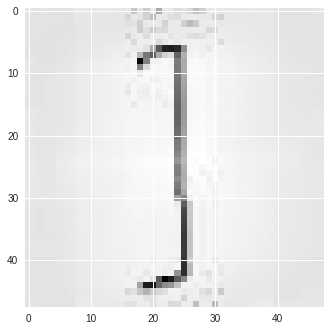

+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 0.996
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 1.000
+class: 0 prob: 0.995
+class: 0 prob: 1.000
+class: 0 

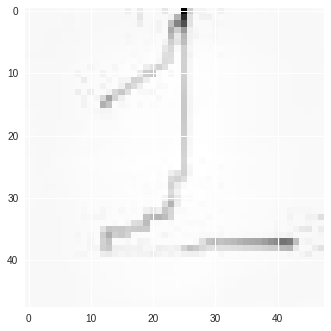

+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 0.998
+class: 1 prob: 0.999
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 0.999
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 0.999
+class: 1 prob: 0.999
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 0.997
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 0.998
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 0.934
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 1.000
+class: 1 prob: 0.953
+class: 1 prob: 1.000
+class: 1 

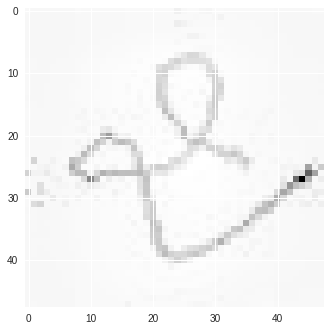

+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 0.995
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 

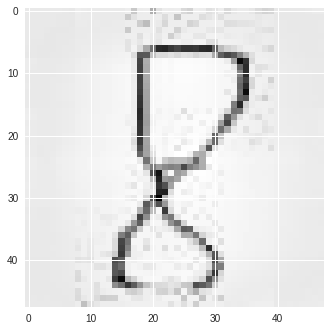

+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 0.999
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 

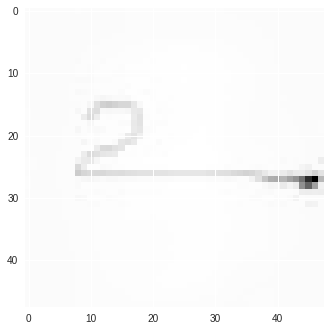

+class: 2 prob: 0.998
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 0.999
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 prob: 1.000
+class: 2 

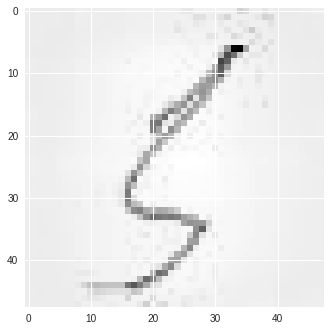

+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 0.999
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 prob: 1.000
+class: 5 

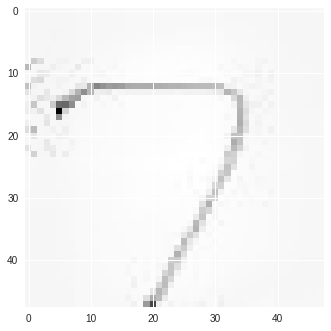

+class: 7 prob: 1.000
+class: 7 prob: 0.723
+class: 7 prob: 1.000
+class: 7 prob: 0.999
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 0.999
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 0.999
+class: 7 prob: 0.988
+class: 7 prob: 0.672
+class: 7 prob: 0.999
+class: 7 prob: 0.672
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 0.825
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 0.999
+class: 7 prob: 1.000
+class: 7 prob: 0.999
+class: 7 prob: 0.998
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 prob: 1.000
+class: 7 

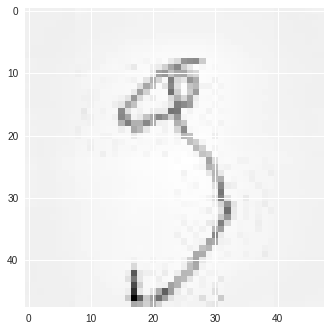

+class: 9 prob: 0.990
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.984
+class: 9 prob: 0.989
+class: 9 prob: 0.991
+class: 9 prob: 0.930
+class: 9 prob: 1.000
+class: 9 prob: 0.951
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.995
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.993
+class: 9 prob: 0.850
+class: 9 prob: 1.000
+class: 9 prob: 0.968
+class: 9 prob: 0.503
+class: 9 prob: 0.995
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.966
+class: 9 prob: 1.000
+class: 9 prob: 0.994
+class: 9 prob: 0.993
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.972
+class: 9 prob: 0.943
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 0.989
+class: 9 prob: 0.988
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.991
+class: 9 

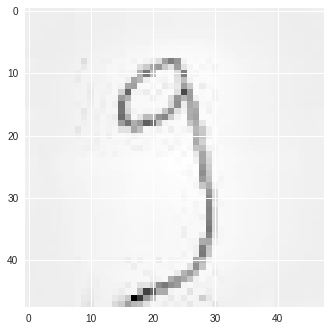

+class: 9 prob: 0.998
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 0.956
+class: 9 prob: 1.000
+class: 9 prob: 0.997
+class: 9 prob: 1.000
+class: 9 prob: 0.991
+class: 9 prob: 1.000
+class: 9 prob: 0.941
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.794
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.897
+class: 9 prob: 0.948
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 0.992
+class: 9 prob: 0.958
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 0.997
+class: 9 prob: 0.998
+class: 9 prob: 0.990
+class: 9 prob: 0.992
+class: 9 prob: 0.999
+class: 9 prob: 0.994
+class: 9 prob: 0.992
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.979
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.999
+class: 9 prob: 0.949
+class: 9 prob: 1.000
+class: 9 

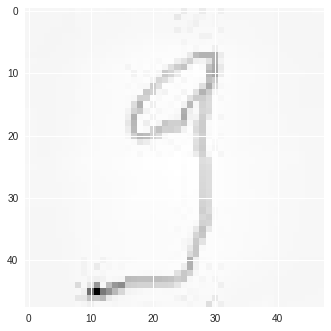

+class: 9 prob: 1.000
+class: 9 prob: 0.891
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.992
+class: 9 prob: 0.991
+class: 9 prob: 1.000
+class: 9 prob: 1.000
-class: y prob: 0.563
Correct: 9


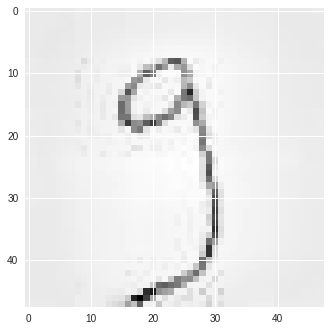

+class: 9 prob: 1.000
+class: 9 prob: 0.980
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.901
+class: 9 prob: 1.000
+class: 9 prob: 1.000
-class: 1 prob: 0.669
Correct: 9


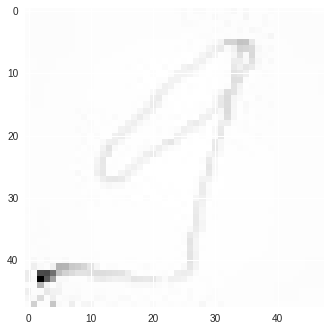

+class: 9 prob: 0.974
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.998
+class: 9 prob: 0.941
+class: 9 prob: 0.998
+class: 9 prob: 0.990
+class: 9 prob: 0.941
+class: 9 prob: 1.000
+class: 9 prob: 0.890
+class: 9 prob: 0.977
+class: 9 prob: 0.998
+class: 9 prob: 0.998
+class: 9 prob: 1.000
+class: 9 prob: 0.555
+class: 9 prob: 0.999
-class: y prob: 0.735
Correct: 9


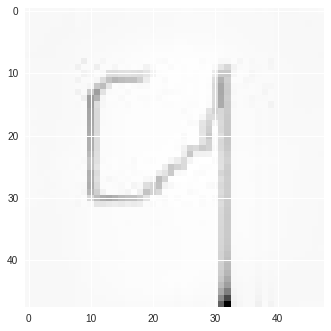

+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.992
+class: 9 prob: 1.000
+class: 9 prob: 0.989
+class: 9 prob: 0.979
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.997
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.879
+class: 9 prob: 0.994
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.963
+class: 9 prob: 1.000
+class: 9 prob: 0.861
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.505
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.993
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.982
+class: 9 prob: 1.000
+class: 9 prob: 0.992
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 0.989
+class: 9 prob: 1.000
+class: 9 

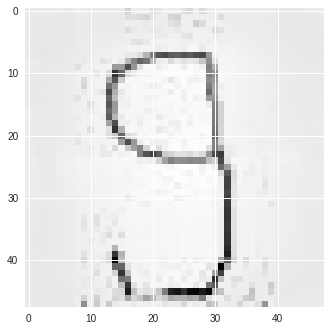

+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.947
+class: 9 prob: 1.000
+class: 9 prob: 0.994
+class: 9 prob: 1.000
+class: 9 prob: 0.999
-class: y prob: 0.544
Correct: 9


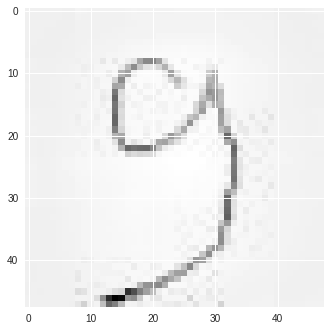

+class: 9 prob: 0.984
-class: y prob: 0.777
Correct: 9


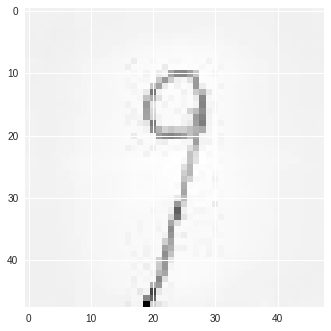

+class: 9 prob: 0.999
+class: 9 prob: 0.982
+class: 9 prob: 0.992
+class: 9 prob: 1.000
+class: 9 prob: 0.992
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 0.992
+class: 9 prob: 0.997
+class: 9 prob: 1.000
+class: 9 prob: 0.888
+class: 9 prob: 0.982
+class: 9 prob: 0.973
+class: 9 prob: 0.998
+class: 9 prob: 0.971
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.999
+class: 9 prob: 0.992
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.624
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.957
+class: 9 prob: 1.000
+class: 9 

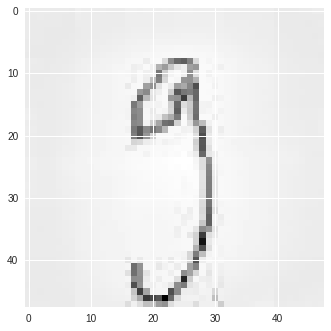

+class: 9 prob: 1.000
+class: 9 prob: 0.999
+class: 9 prob: 0.999
+class: 9 prob: 0.999
+class: 9 prob: 0.948
+class: 9 prob: 1.000
+class: 9 prob: 0.975
+class: 9 prob: 1.000
+class: 9 prob: 1.000
+class: 9 prob: 0.998
+class: - prob: 0.980
+class: - prob: 0.949
+class: - prob: 0.916
+class: - prob: 0.931
+class: - prob: 0.776
+class: - prob: 0.982
+class: - prob: 0.940
+class: - prob: 0.962
+class: - prob: 0.850
+class: - prob: 0.940
+class: - prob: 0.935
+class: - prob: 0.906
+class: - prob: 0.953
+class: - prob: 0.948
+class: - prob: 0.956
+class: - prob: 0.973
+class: - prob: 0.978
+class: - prob: 0.928
+class: - prob: 0.972
+class: - prob: 0.870
+class: - prob: 0.858
+class: - prob: 0.660
+class: - prob: 0.958
+class: - prob: 0.880
+class: - prob: 0.979
+class: - prob: 0.967
+class: - prob: 0.873
+class: - prob: 0.907
+class: - prob: 0.987
+class: - prob: 0.881
+class: - prob: 0.989
+class: - prob: 0.961
+class: - prob: 0.913
+class: - prob: 0.891
+class: - prob: 0.946
+class: - 

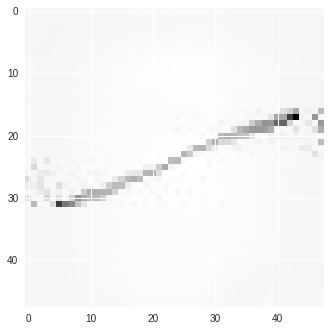

+class: - prob: 0.954
+class: - prob: 0.966
-class: = prob: 0.910
Correct: -


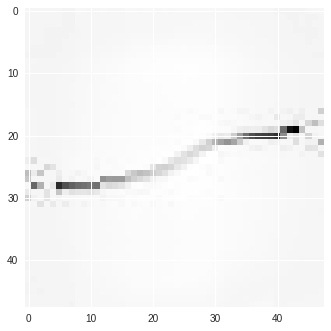

+class: - prob: 0.864
+class: - prob: 0.823
+class: - prob: 0.946
+class: - prob: 0.948
+class: - prob: 0.746
+class: - prob: 0.943
+class: - prob: 0.990
+class: - prob: 0.966
+class: - prob: 0.985
+class: - prob: 0.914
+class: - prob: 0.975
+class: - prob: 0.968
+class: - prob: 0.989
+class: - prob: 0.972
+class: - prob: 0.974
+class: - prob: 0.699
+class: - prob: 0.969
+class: - prob: 0.973
+class: - prob: 0.968
+class: - prob: 0.932
+class: - prob: 0.986
+class: - prob: 0.922
-class: = prob: 0.930
Correct: -


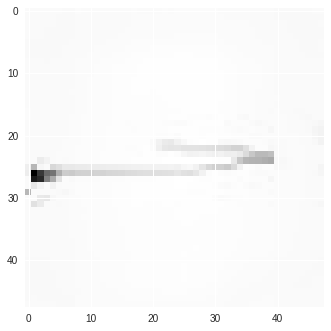

+class: - prob: 0.947
+class: - prob: 0.972
+class: - prob: 0.936
+class: - prob: 0.987
+class: - prob: 0.926
+class: - prob: 0.978
+class: - prob: 0.862
+class: - prob: 0.934
+class: - prob: 0.925
+class: - prob: 0.962
+class: - prob: 0.949
+class: - prob: 0.927
+class: - prob: 0.707
+class: - prob: 0.811
+class: - prob: 0.973
+class: - prob: 0.845
+class: - prob: 0.931
+class: - prob: 0.953
+class: - prob: 0.913
+class: - prob: 0.957
+class: - prob: 0.951
+class: - prob: 0.853
+class: - prob: 0.606
+class: - prob: 0.928
+class: - prob: 0.831
+class: - prob: 0.941
+class: - prob: 0.913
+class: - prob: 0.978
+class: - prob: 0.927
+class: - prob: 0.900
+class: - prob: 0.958
+class: - prob: 0.766
+class: - prob: 0.854
+class: - prob: 0.978
+class: - prob: 0.901
+class: - prob: 0.798
+class: - prob: 0.898
+class: - prob: 0.943
+class: - prob: 0.993
+class: - prob: 0.696
+class: - prob: 0.958
+class: - prob: 0.855
-class: 6 prob: 0.532
Correct: -


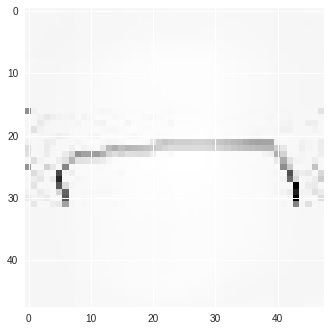

+class: - prob: 0.986
+class: - prob: 0.976
+class: - prob: 0.968
+class: - prob: 0.935
+class: - prob: 0.988
+class: - prob: 0.877
+class: - prob: 0.900
+class: - prob: 0.940
+class: - prob: 0.990
+class: - prob: 0.843
+class: - prob: 0.938
+class: - prob: 0.951
+class: - prob: 0.934
+class: - prob: 0.856
+class: - prob: 0.970
+class: - prob: 0.878
+class: - prob: 0.969
+class: - prob: 0.987
+class: - prob: 0.749
+class: - prob: 0.861
+class: - prob: 0.997
+class: - prob: 0.985
+class: - prob: 0.949
+class: - prob: 0.918
+class: - prob: 0.885
+class: - prob: 0.992
+class: - prob: 0.940
+class: - prob: 0.862
+class: - prob: 0.806
+class: - prob: 0.989
+class: - prob: 0.997
+class: - prob: 0.931
+class: - prob: 0.912
+class: - prob: 0.963
+class: - prob: 0.989
+class: - prob: 0.996
+class: - prob: 0.969
+class: - prob: 0.959
+class: - prob: 0.989
+class: - prob: 0.799
+class: - prob: 0.920
+class: - prob: 0.978
+class: - prob: 0.920
+class: - prob: 0.992
+class: - prob: 0.983
+class: - 

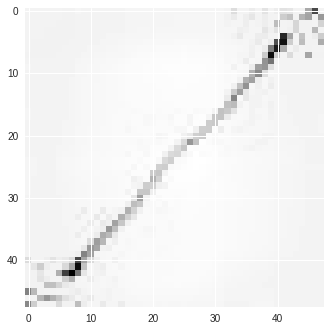

+class: - prob: 0.971
+class: - prob: 0.931
+class: - prob: 0.846
+class: - prob: 0.980
+class: - prob: 0.940
+class: - prob: 0.975
+class: - prob: 0.953
+class: - prob: 0.878
+class: - prob: 0.973
+class: - prob: 0.814
+class: - prob: 0.831
+class: - prob: 0.968
+class: - prob: 0.713
+class: - prob: 0.938
+class: - prob: 0.966
+class: - prob: 0.957
+class: - prob: 0.944
+class: - prob: 0.930
+class: - prob: 0.826
+class: - prob: 0.978
+class: - prob: 0.969
+class: - prob: 0.935
+class: - prob: 0.981
+class: - prob: 0.808
+class: - prob: 0.967
+class: - prob: 0.927
+class: - prob: 0.920
+class: - prob: 0.982
+class: - prob: 0.949
+class: - prob: 0.973
+class: - prob: 0.930
+class: - prob: 0.944
+class: - prob: 0.926
+class: - prob: 0.930
+class: - prob: 0.987
+class: - prob: 0.971
+class: - prob: 0.906
+class: - prob: 0.878
+class: - prob: 0.841
+class: - prob: 0.924
+class: - prob: 0.929
+class: - prob: 0.861
+class: - prob: 0.951
+class: - prob: 0.907
+class: - prob: 0.880
+class: - 

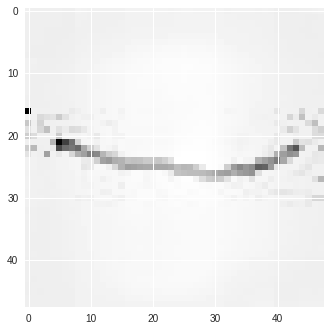

+class: - prob: 0.964
+class: - prob: 0.752
+class: - prob: 0.850
+class: - prob: 0.952
+class: - prob: 0.819
+class: - prob: 0.914
+class: - prob: 0.860
+class: - prob: 0.970
+class: - prob: 0.954
+class: - prob: 0.952
+class: - prob: 0.898
+class: - prob: 0.919
+class: - prob: 0.677
+class: - prob: 0.968
+class: - prob: 0.928
+class: - prob: 0.872
+class: - prob: 0.947
+class: - prob: 0.925
+class: - prob: 0.927
+class: - prob: 0.989
+class: - prob: 0.967
+class: - prob: 0.974
+class: - prob: 0.987
+class: - prob: 0.949
+class: - prob: 0.979
+class: - prob: 0.992
+class: - prob: 0.846
+class: - prob: 0.931
+class: - prob: 0.975
+class: - prob: 0.954
+class: - prob: 0.971
+class: - prob: 0.976
+class: - prob: 0.971
+class: - prob: 0.971
+class: - prob: 0.945
-class: = prob: 0.532
Correct: -


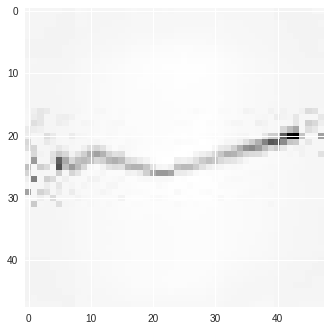

+class: - prob: 0.826
+class: - prob: 0.843
+class: - prob: 0.955
+class: - prob: 0.954
+class: - prob: 0.988
+class: - prob: 0.980
+class: - prob: 0.813
+class: - prob: 0.650
+class: - prob: 0.849
+class: - prob: 0.937
+class: - prob: 0.836
-class: = prob: 0.857
Correct: -


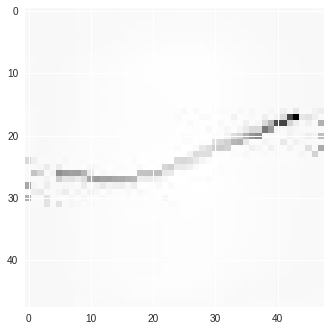

-class: = prob: 0.614
Correct: -


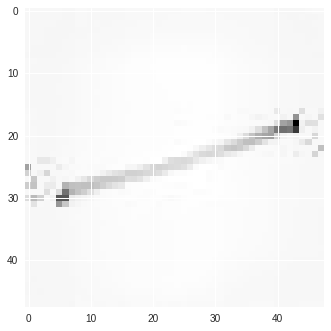

+class: - prob: 0.980
+class: + prob: 1.000
+class: + prob: 0.999
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.995
+class: + prob: 0.998
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.984
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + 

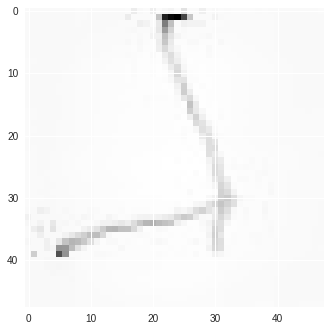

+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.922
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.980
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.998
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.986
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + 

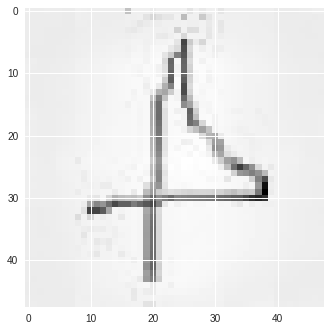

+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.988
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
-class: 1 prob: 0.783
Correct: +


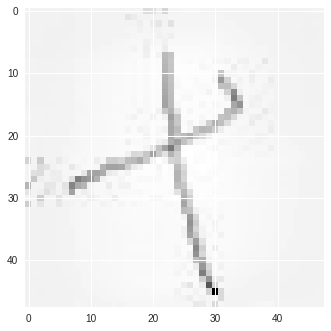

+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.999
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 0.878
+class: + prob: 0.970
+class: + prob: 0.999
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: + prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = 

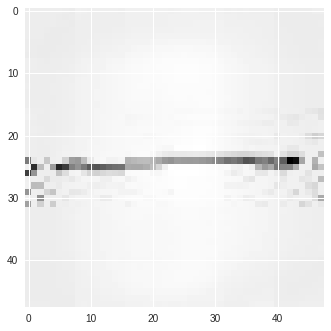

+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 0.990
+class: = prob: 0.997
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 0.999
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: = prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 0.999
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 0.994
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 0.996
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 1.000
+class: leq prob: 1.000


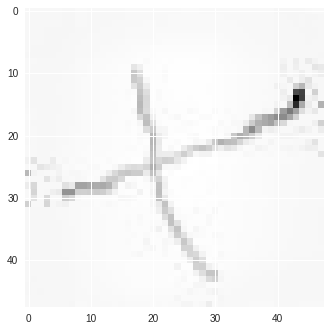

+class: x prob: 1.000
-class: y prob: 0.587
Correct: x


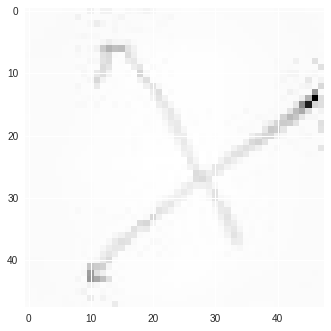

+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 0.994
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 0.999
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 0.987
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 0.943
+class: x prob: 1.000
+class: x prob: 1.000
+class: x prob: 1.000
+class: x 

In [24]:
small_test_idx = list(range(0,nof_test_images,10))
print("Testing on #images: ", len(small_test_idx))
plt.hist(test_labels[small_test_idx], nof_labels)
plt.show()
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
     x = {"x": test_images[small_test_idx]},
     y = test_labels[small_test_idx],
     num_epochs = 1,
     shuffle = False
)
eval_results = classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)
pred_results = classifier.predict(input_fn=eval_input_fn)
for img,pred,real in zip(test_images[small_test_idx],pred_results,test_labels[small_test_idx]):
  if pred['classes'] == real:
    print("+class: %s prob: %.3f" % (label_names[pred['classes']],pred['probabilities'][pred['classes']]))
  else:
    print("-class: %s prob: %.3f" % (label_names[pred['classes']],pred['probabilities'][pred['classes']]))
    print("Correct: %s" % label_names[real])
    plt.imshow(img, cmap='gray')
    plt.show()